# Wine Enthusiast Descriptions
### Mark Murgia

In [1]:
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet, fcluster
from scipy.spatial.distance import pdist
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
import nltk
from nltk.stem.snowball import SnowballStemmer
from textblob import TextBlob, Word
from nltk.stem.wordnet import WordNetLemmatizer
import sklearn.manifold
import multiprocessing
import re
import sys
default_stdout = sys.stdout
default_stderr = sys.stderr
reload(sys)
sys.setdefaultencoding('utf-8')
sys.stdout = default_stdout
sys.stderr = default_stderr
plt.style.use('fivethirtyeight')
%matplotlib inline

In [3]:
### I had to reload sys because of the weird coding of so many special characters from foreign languages in my
### descriptions. For some reason this solution worked along with my decoding further in the notebook


### test test test
print 12

12


# Investigating Wine Descriptions
### In this notebook I will explore a dataset supplied by zackthoutt on kaggle, that contains information on wine descriptions. This data was scraped from Wine Enthusiast Magazines website. 

## Importing my wine description dataset...

In [3]:
winedf = pd.read_csv('./datasets/winemag-data_first150k.csv', index_col=0)

In [4]:
winedf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150930 entries, 0 to 150929
Data columns (total 10 columns):
country        150925 non-null object
description    150930 non-null object
designation    105195 non-null object
points         150930 non-null int64
price          137235 non-null float64
province       150925 non-null object
region_1       125870 non-null object
region_2       60953 non-null object
variety        150930 non-null object
winery         150930 non-null object
dtypes: float64(1), int64(1), object(8)
memory usage: 12.7+ MB


### The first look into our data is pretty encouraging, the column types are correct and most columns are full.

In [5]:
winedf.head()

,country,description,designation,points,price,province,region_1,region_2,variety,winery
0,US,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz
1,Spain,"Ripe aromas of fig, blackberry and cassis are ...",Carodorum Selección Especial Reserva,96,110.0,Northern Spain,Toro,NaN,Tinta de Toro,Bodega Carmen Rodríguez
2,US,Mac Watson honors the memory of a wine once ma...,Special Selected Late Harvest,96,90.0,California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley
3,US,"This spent 20 months in 30% new French oak, an...",Reserve,96,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi
4,France,"This is the top wine from La Bégude, named aft...",La Brûlade,95,66.0,Provence,Bandol,NaN,Provence red blend,Domaine de la Bégude


### Running drop duplicates on web scraped data is a good idea to ensure each entry we have is truly unique.

In [6]:
winedf.shape

(150930, 10)

In [7]:
winedf = winedf.drop_duplicates()

In [8]:
winedf.shape

(97851, 10)

### the dataset is cut in half, but we still have enough to do some meaningful analysis.

In [9]:
winedf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 97851 entries, 0 to 149639
Data columns (total 10 columns):
country        97848 non-null object
description    97851 non-null object
designation    67955 non-null object
points         97851 non-null int64
price          89131 non-null float64
province       97848 non-null object
region_1       81919 non-null object
region_2       39491 non-null object
variety        97851 non-null object
winery         97851 non-null object
dtypes: float64(1), int64(1), object(8)
memory usage: 8.2+ MB


### The two columns with the most missing values, I actually do not need. In theory it would be nice if it was filled properly but in this case province and region_1 go into enough detail to provide more than enough regions to work with for this initial experiment. Designation is another feature that would be nice but different designations carry different meanings country to country. Unless I was analyzing countries seperatley, it is useless.


In [10]:
winedf.drop('region_2',axis=1,inplace=True)
winedf.drop('designation',axis=1, inplace=True)

### Next I will explore two columns that both have a similar representation issue. In order to get meaningful groups, i can set a threshold to make sure I have enough descriptions per country and per varietal. In the end I should end up with the most popular countries and varietals.

In [11]:
# intial value counts of country
winedf.country.value_counts().sum

<bound method Series.sum of US                        40544
Italy                     14850
France                    14459
Spain                      5443
Chile                      3735
Portugal                   3508
Argentina                  3447
Australia                  3152
Austria                    1959
New Zealand                1865
Germany                    1529
South Africa               1481
Greece                      541
Israel                      370
Canada                      149
Hungary                     139
Romania                     106
Slovenia                     72
Croatia                      70
Bulgaria                     56
Mexico                       54
Uruguay                      52
Turkey                       46
Moldova                      46
Georgia                      30
Lebanon                      27
Cyprus                       15
Brazil                       14
Macedonia                    12
Morocco                      11
Serbia      

In [12]:
# setting my threshold at 100 entries to make the cut
new = winedf[winedf.groupby('country')['country'].transform('size') > 100]

### Next, the initial varietal counts

In [13]:
new.variety.value_counts().sum 

<bound method Series.sum of Pinot Noir                       9268
Chardonnay                       9134
Cabernet Sauvignon               8237
Red Blend                        6397
Bordeaux-style Red Blend         5166
Sauvignon Blanc                  4018
Syrah                            3655
Riesling                         3575
Merlot                           3157
Zinfandel                        2409
Sangiovese                       2153
Malbec                           1968
Rosé                             1894
White Blend                      1818
Tempranillo                      1620
Portuguese Red                   1441
Nebbiolo                         1336
Sparkling Blend                  1292
Shiraz                           1248
Corvina, Rondinella, Molinara    1118
Rhône-style Red Blend            1046
Pinot Gris                        893
Cabernet Franc                    882
Sangiovese Grosso                 870
Bordeaux-style White Blend        856
Viognier              

### Setting my threshold at 150 gives me enough descriptions to build a nice vocabulary for each varietal.

In [14]:
newer = new[new.groupby('variety')['variety'].transform('size') > 150]

### Bar charts are a nice way to see house the distribution on these two columns. In the end I do end up with a pretty thorough list of the most popular red and whie wine varieties. Rose and Port also make the cut too, which adds nice categories to the dataset as well.

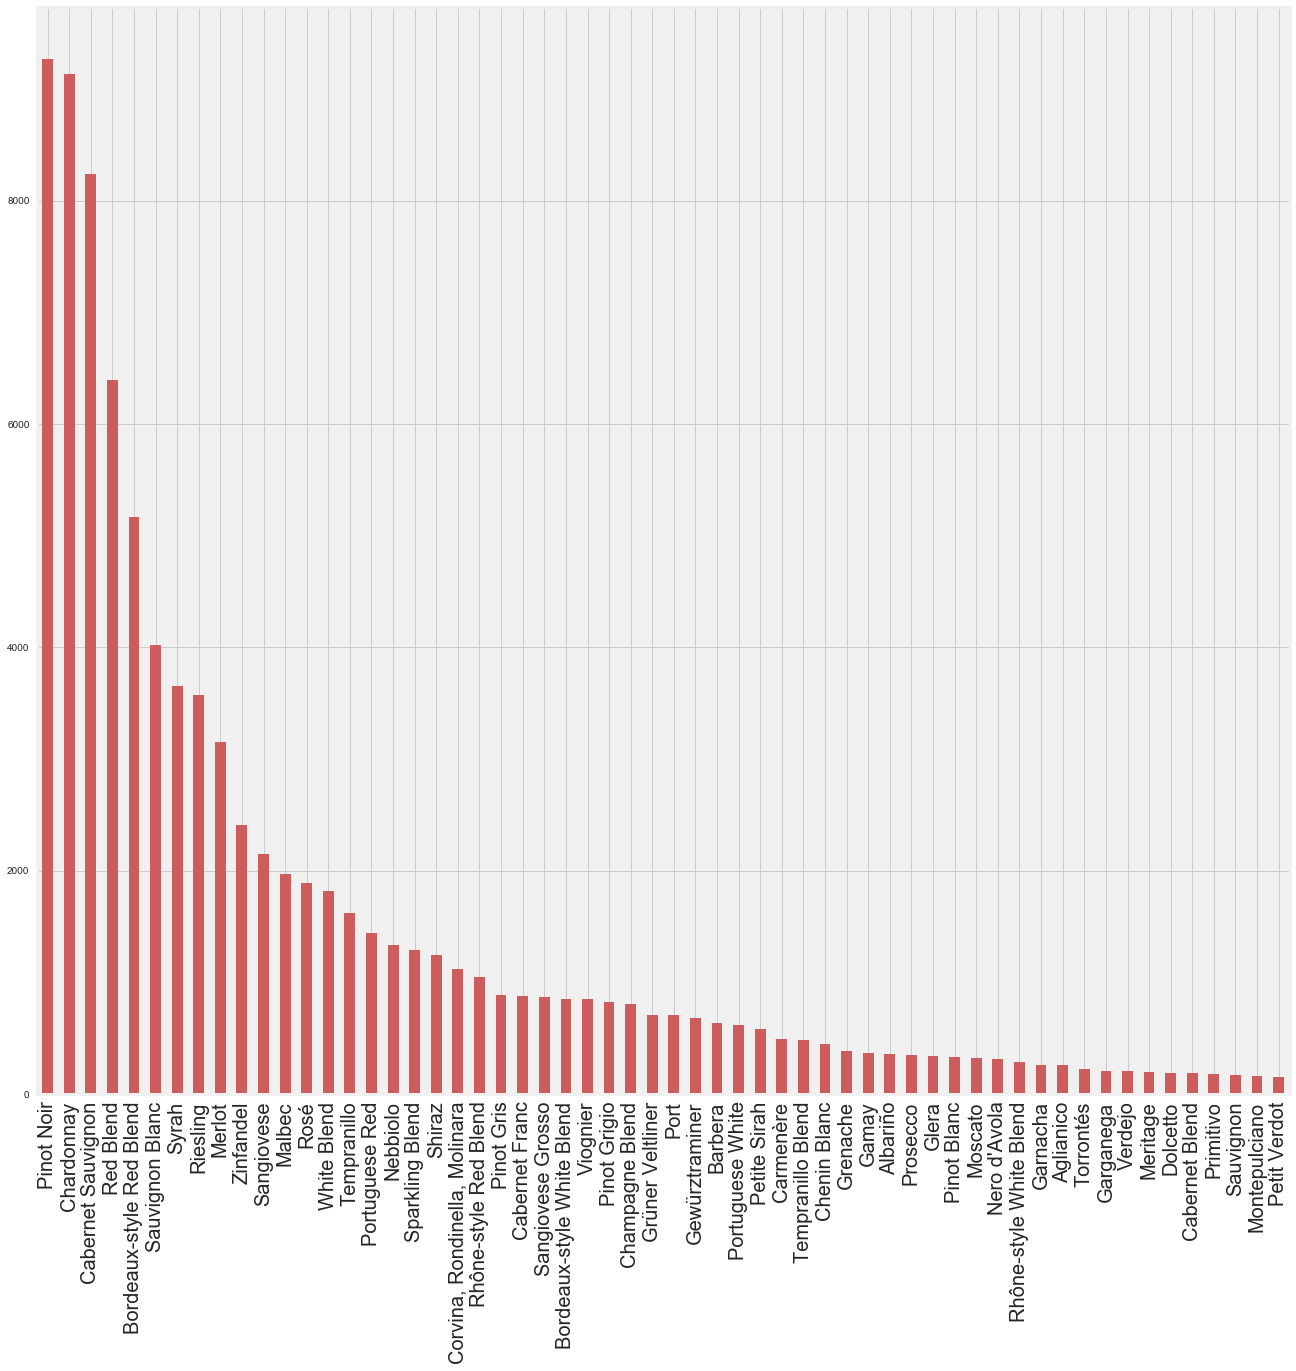

In [15]:
newer.variety.value_counts().plot(kind='bar', figsize=(20,20), color='indianred')
plt.xticks(fontsize=20)
plt.show()

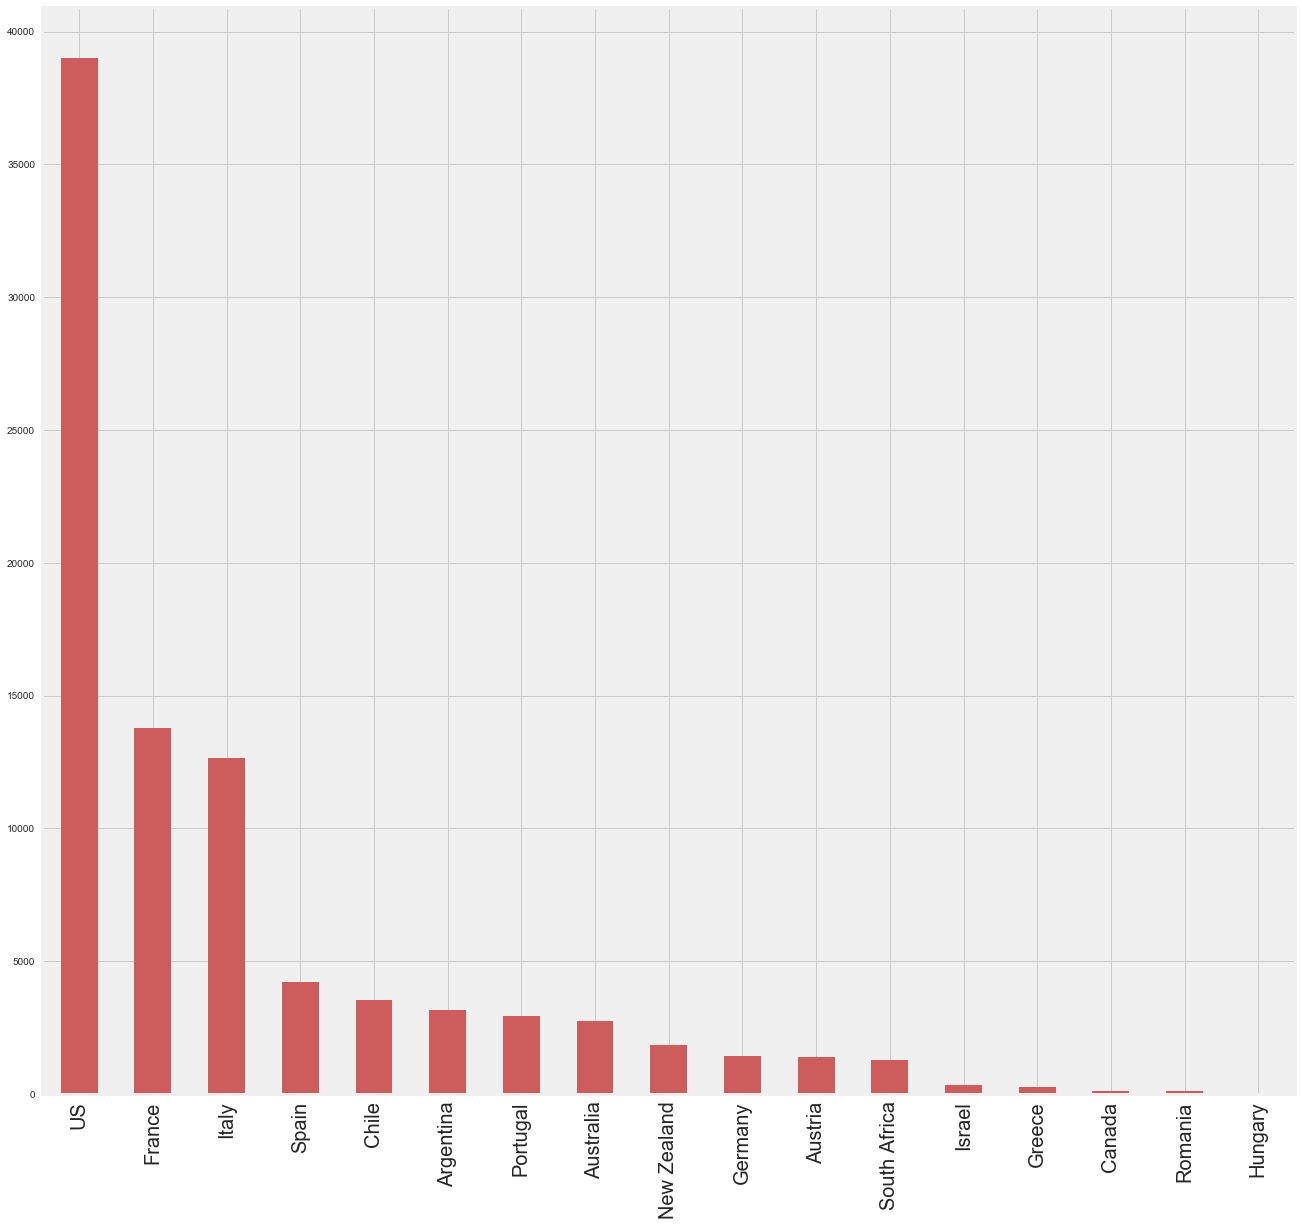

In [16]:
newer.country.value_counts().plot(kind='bar', figsize=(20,20), color='indianred')
plt.xticks(fontsize=20)
plt.show()

### These varietals have better representation. We also got rid of the more obscure varietals and countries along with them. Now lets explore a feature I engineered to group my wines by kind.

In [17]:
# There were a group of wines only labeled Saugvinon when they should of been Sauvignon Blanc
newer.variety = newer.variety.map(lambda x: 'Sauvignon Blanc' if x == 'Sauvignon' else x)

/anaconda/lib/python2.7/site-packages/pandas/core/generic.py:2999: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [18]:
# Here I build a list of white varieties and blends belong to what category, I then built a function, to compare to
# each list and return a kind label.
red= ['Meritage','Dolcetto','Cabernet Blend','Primitivo','Montepulciano','Petit Verdot','Garnacha',                          
'Aglianico',"Nero d'Avola",'Grenache','Gamay','Petite Sirah','Carmenère','Tempranillo Blend','Barbera',\
'Cabernet Franc','Sangiovese Grosso','Shiraz','Corvina, Rondinella, Molinara','Rhône-style Red Blend','Tempranillo',                      
'Portuguese Red','Nebbiolo','Merlot','Zinfandel','Sangiovese','Malbec','Syrah','Cabernet Sauvignon',               
'Red Blend','Bordeaux-style Red Blend','Pinot Noir']

white = ['Torrontés','Garganega','Verdejo','Rhône-style White Blend','Glera',                             
'Pinot Blanc','Chenin Blanc','Albariño','Portuguese White','Gewürztraminer','Grüner Veltliner',\
'Bordeaux-style White Blend', 'Viognier', 'Pinot Grigio','Pinot Gris','White Blend','Riesling','Sauvignon Blanc',\
'Chardonnay']

sparkling = ['Prosecco','Champagne Blend','Sparkling Blend','Moscato']

fortified = ['Port']

rose = ['Rosé']

def redkind(x):
    if x in red:
        return 'red'
    elif x in white:
        return 'white'
    elif x in sparkling:
        return 'sparkling'
    elif x in fortified:
        return 'fortified'
    elif x in rose:
        return 'rose'

In [19]:
len(white)

19

In [20]:
# Running this will create a new column in my Dataframe that ctegorizes each row by kind.
newer['kind'] = newer.variety.map(redkind)

/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [21]:
# Now I can see representation in my Data in a whole new way. I have far more red wine descriptions than any other.
newer['kind'].value_counts().sum

<bound method Series.sum of red          56851
white        26579
sparkling     2778
rose          1894
fortified      707
Name: kind, dtype: int64>

In [22]:
# I can now see interesting things like average price and points by kind
print "The average price of reds is: " + str(round(newer[newer['kind'] == 'red']['price'].mean(),2))
print "The average score of reds is: " + str(round(newer[newer['kind'] == 'red']['points'].mean()))
print "The average price of whites is: " + str(round(newer[newer['kind'] == 'white']['price'].mean(),2))
print "The average score of whites is: " + str(round(newer[newer['kind'] == 'white']['points'].mean()))
print "The average price of sparkling is: " + str(round(newer[newer['kind'] == 'sparkling']['price'].mean(),2))
print "The average score of sparkling is: " + str(round(newer[newer['kind'] == 'sparkling']['points'].mean()))
print "The average price of rose is: " + str(round(newer[newer['kind'] == 'rose']['price'].mean(),2))
print "The average score of rose is: " + str(round(newer[newer['kind'] == 'rose']['points'].mean()))
print "The average price of fortified is: " + str(round(newer[newer['kind'] == 'fortified']['price'].mean(),2))
print "The average score of fortified is: " + str(round(newer[newer['kind'] == 'fortified']['points'].mean()))

The average price of reds is: 38.21
The average score of reds is: 88.0
The average price of whites is: 26.58
The average score of whites is: 88.0
The average price of sparkling is: 37.21
The average score of sparkling is: 88.0
The average price of rose is: 17.83
The average score of rose is: 87.0
The average price of fortified is: 54.84
The average score of fortified is: 89.0


In [23]:
newer.describe()

,points,price
count,88809.000000,80805.000000
mean,88.001678,34.347045
std,3.241466,38.453149
min,80.000000,4.000000
25%,86.000000,16.000000
50%,88.000000,25.000000
75%,90.000000,40.000000
max,100.000000,2300.000000


### Now lets explore null values...

In [24]:
newer.isnull().sum()

country            0
description        0
points             0
price           8004
province           0
region_1       13255
variety            0
winery             0
kind               0
dtype: int64

In [25]:
# In order to fill price I will impute the mean.
newer.price = newer.price.fillna(newer.price.median())

In [26]:
# For Missing region_1 data, I fill what is in the province column. region_! just goes into more detail than
# province so where region_1 is missing the relateing province will suffice.
newer.region_1.fillna(value=newer.province, inplace=True)

/anaconda/lib/python2.7/site-packages/pandas/core/generic.py:3549: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


### Now lets look points and price that would make interesting targets for predictitons.

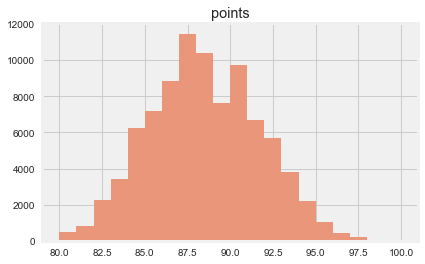

In [27]:
newer.hist('points', bins = 20, color='darksalmon')
plt.show()

#### points looks like a nice distribution that might make a good target for future experiments.

### Here I am also playing to see what country and province has the highest average score and price in the set

In [31]:
# country count atleast 50
abba = newer[newer.groupby('country')['country'].transform('size') > 50]

newer.country.value_counts().sum

<bound method Series.sum of US              38984
France          13767
Italy           12648
Spain            4229
Chile            3522
Argentina        3176
Portugal         2930
Australia        2741
New Zealand      1827
Germany          1415
Austria          1409
South Africa     1279
Israel            341
Greece            274
Canada            125
Romania            92
Hungary            50
Name: country, dtype: int64>

## I can grouby country and aggregate and sort by mean point and price!

In [32]:
mmm = newer.groupby('country').mean()

In [33]:
mmm.sort_values('points', ascending=False).head(20)

,points,price
country,,
Austria,89.562101,30.769340
Germany,88.980212,41.738516
France,88.943270,39.720346
Canada,88.720000,34.096000
Italy,88.528463,37.162160
Portugal,88.165529,27.983618
Australia,87.950018,31.593579
US,87.920275,34.317310
New Zealand,87.639847,24.617953


In [34]:
mmm.sort_values('price', ascending=False).head(10)

,points,price
country,,
Germany,88.980212,41.738516
France,88.943270,39.720346
Italy,88.528463,37.162160
US,87.920275,34.317310
Canada,88.720000,34.096000
Australia,87.950018,31.593579
Austria,89.562101,30.769340
Israel,87.439883,30.697947
Hungary,85.680000,29.060000


## I can do the same thing with province, setting my representation threshold at 200.

In [37]:
baab = newer[newer.groupby('province')['province'].transform('size') > 200]

In [38]:
nnn = baab.groupby('province').mean()

### Of course Champagne leads the way here...

In [39]:
nnn.sort_values('price', ascending=False).head(10)

,points,price
province,,
Champagne,90.197339,72.896896
Rheingau,89.603922,72.368627
Burgundy,89.505502,60.131706
Port,88.714765,49.884228
Tuscany,89.299771,45.096110
Wachau,90.767347,44.587755
Piedmont,89.134321,44.208893
Rhône Valley,88.744552,41.673123
Lombardy,89.122744,37.884477


In [40]:
nnn.sort_values('points', ascending=False).head(10)

,points,price
province,,
Wachau,90.767347,44.587755
Kamptal,90.718750,33.906250
Champagne,90.197339,72.896896
Rheingau,89.603922,72.368627
Mosel,89.589322,37.043121
Burgundy,89.505502,60.131706
Bordeaux,89.448089,34.196109
Tuscany,89.299771,45.096110
Douro,89.265487,29.026549


### but at the end of the day the ultimate goal is to utilize NLP to cluster varieties, lets breakdown the description column...

In [42]:
newer.reset_index(inplace=True)

In [43]:
newer[['description']].head()

,description
0,This tremendous 100% varietal wine hails from ...
1,Mac Watson honors the memory of a wine once ma...
2,"This spent 20 months in 30% new French oak, an..."
3,This re-named vineyard was formerly bottled as...
4,The producer sources from two blocks of the vi...


In [44]:
stopWords = list(set(stopwords.words('english')))

In [70]:
def replace_end(x):
    new_descript = []
    for word in x.split():
        if word.endswith('ies'):
            New_word = word[:-3]+'y'
            new_descript.append(New_word.lower())
        elif word == 'currant':
            New_word = 'currants'
            new_descript.append(New_word.lower())
        elif word == 'cassis':
            New_word = 'currants'
            new_descript.append(New_word.lower())
        elif word == 'tannic':
            New_word = 'tannins'
            new_descript.append(New_word.lower())
        elif word == 'zest':
            New_word = 'zesty'
            new_descript.append(New_word.lower())
        elif word == 'fruits':
            New_word = 'fruit'
            new_descript.append(New_word.lower())
        elif word == 'accented':
            New_word = 'accents'
            new_descript.append(New_word.lower())
        elif word == 'accent':
            New_word = 'accents'
            new_descript.append(New_word.lower())
        elif word == 'youthful':
            New_word = 'youth'
            new_descript.append(New_word.lower())
        else:
            new_descript.append(word.lower())
    return " ".join(new_descript)

In [46]:
replace_end('I want a wine with tannic tannins currant blackberries zest cassis and red fruits')

'I want a wine with tannins tannins currants blackberry zesty currants and red fruit'

In [47]:
newer2 = newer.copy()

In [71]:
newer['description'] = newer.description.map(replace_end)

/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [49]:
newer2['description'] = newer.description.map(replace_end)

In [72]:
newer[['description']].head()

,description
0,this tremendous 100% varietal wine hails from ...
1,mac watson honors the memory of a wine once ma...
2,"this spent 20 months in 30% new french oak, an..."
3,this re-named vineyard was formerly bottled as...
4,the producer sources from two blocks of the vi...


In [51]:
newer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88809 entries, 0 to 88808
Data columns (total 10 columns):
index          88809 non-null int64
country        88809 non-null object
description    88809 non-null object
points         88809 non-null int64
price          88809 non-null float64
province       88809 non-null object
region_1       88809 non-null object
variety        88809 non-null object
winery         88809 non-null object
kind           88809 non-null object
dtypes: float64(1), int64(2), object(7)
memory usage: 6.8+ MB


In [51]:
stopWords = list(set(stopwords.words('english')))

In [50]:
### Here I am a building a list of stop words that are meaningless to what I want which are smell and 
### taste descriptions.
stops = ['wine','pinot noir','viognier','without','winery','vineyard','like','sample','merlot','cabernet saugvignon',\
        'sauvignon','cabernet franc','would','shows','cabernet','also','year','years','pinot','91','92','00','000',\
        '90','89','drink','100','varietal','88','93','94','offers','delivers','torrontés','garganega','verdejo','rhône-style White Blend','Glera',                             
'pinot blanc','chenin blanc','albariño','portuguese white','gewürztraminer','grüner veltliner',\
'bordeaux-style white blend','pinot grigio','pinot gris','white blend','riesling','sauvignon blanc',\
'chardonnay','meritage','dolcetto','cabernet blend','primitivo','montepulciano','petit verdot','garnacha',                          
'aglianico',"nero d'avola",'grenache','gamay','petite sirah','carmenère','tempranillo blend','barbera',\
'cabernet franc','sangiovese grosso','shiraz','corvina, rondinella, molinara','rhône-style red blend','tempranillo',                      
'portuguese red','nebbiolo','merlot','zinfandel','sangiovese','malbec','syrah','cabernet sauvignon',               
'red blend','bordeaux-style red blend','opens','petit','verdot','sirah','bordeaux','blend','bottle','feels','flavors',\
'cab','franc','nero','avola','drinking','10','15','20','2010','2015','one','best','palate','50','months','14','87',\
'01','001','02','003','03','002','0','08','02s','03s','04s','01s','05s','008','04','05','07','zweigelt','top','using',\
'cases','056','06','16','kessler','zu','salm','zotovich','bottles','zorro','finest','064','08s','06s','07s','082',\
'080','082','09','11','12','09s','1000','100g','101','154','102','103','104','105','case','106','107','108','109',\
'zoppega','decide','acres','acre','110','111','112','1100s','10th','birthday','vintage','zoom','zooming',\
'zuccardi','114','115','116','117','118','119','120','bottling','castello','11th','abacela','made','zonin','ripasso',\
'12th','122','123','124','125','1170','1200','di','foot','zwiegelt','1232','1258','126','128','129','12g','13','17',\
'valpolicella','brother','130','130th','132','produced','annoversary','gallon','castera','comes','13th','century',\
'release','1396','140','vine','monna','wines','135','1425','1475','1492','1498','14g','2020','14th','nera','quinta',\
'generation','150','anniversary','worth','1500','1500s','15g','150th','151','152','1522','153','zone','think','feet',\
'lost','cuvee','barolo','de','15th','tower','zitsa','zoemie','zisola','area','zonchera','160','1600','zips',\
'ziraldo','16th','16g','1610','1618','1624','165','1674','1698','legacy','owner','may','weinviertel','zin','zippy',\
'170','1700s','1705','1709','170th','171','1716','174','175','marsala','1789','label','1791','220','1794','deinhard',\
'17g','17th','residual','nun','chateau','96','recall','18','180','today','price','oakville','rose','1800s','1803','1806',\
'1808','1811','estate','surrounds','1819','183','1841','1843','1844','185','1850s','1858','along','named',\
'easton','premier','1860s','says','sb','ml','1873','1875','187','1865','1870','san','antonin','reserve','1877',\
'1880s','1881','1882','1886','1889','sugar','planting','house','1890s','1892','1893','1895','1898','g','189g','genuinely',\
'subsequently','joseph','owned','family','edition','2000','18th','19th','19','2004','2012','190','search','seppeltsfield',\
'190','1900s','1900','1901','1944','2006','1901','1902','1903','1904','1905','60','newest','oldest','germano',\
'produces','1908','1909','1910','1911','1912','1913','1914','1915','1916','1917','1918','grandfathers','carol','icon',\
'historic','leading','california','ferruccio','1920','1920s','1925','1926','1927','1930','california','alessio',\
'chevy','description','treviso','1930','1930s','1924','northern','1932','1935','1936','1939','columbia','2007',\
'1937','1940','1940s','1945','1947','1948','1950s','2016','noir','1952','1955','1956','1960s','1959','1961','1962',\
'david','finds','1993','1964','1965','1966','1967','1973','2001','2002','2003','2004','2005','2006','2007','2008',\
'2009','2010','amarone','harvest','2011','2012','2013','2014','pinots','2015','2016','2017','2018','2019',\
'21','beyond','2020','2030','2021','2024','2030','2022','2025','mourvedre','petite','blanc','petit','hours',\
'22','23','24','25','26','27','28','29','30','31','32','33','34','35','carignan','carmenere','cinsault','ago',\
'imported','225','300','37','38','40','43','45','46','47','500','liter','48','53','54','roussanne','meters',\
'main','albarino','55','57','58','600','39','777','667','65','64','70','75','80','90','alicante','bianco','viura',\
'rest','grillo','zins','zinny','canaiolo','smaller','85','86','84','95','97','ability','able','grow','98','99','new zealand',\
'francois','moved','zio','zinkoepfle','zinman','zinners',u'215', u'212', u'210', u'575', u'80g', u'452', u'093', u'227', u's15',\
u'd122', u'496', u'138', u'd2', u'2004s', u'ce2v', u'21st', u'690', u'99s', u'2020s', u'624', u'407', u'320', u'289', u'5l',\
u'523', u'341', u'544', u'400', u'280', u'283', u'813', u'349', u'287', u'40g', u'g3', u'3m', u'76s', u'49g', u'670', \
u'263', u'260', u'1950', u'960', u'69', u'74', u'54g', u'2t', u'v90', u'59', u'2007s', u'2s', u'425', u'56', u'51',\
u'62', u'52', u'415', u'416', u'81', u'20152019', u'2a', u'1998', u'296', u'370', u'375', u'374', u'20th', u'24g', \
u'318', u'33rd', u'850', u't2', u'197', u'310', u'317', u'872', u'192', u'270', u'68', u'272', u'7up', u'274', u'275',\
u'440', u'277', u'22012', u'83', u'475', u'2010s', u'30g', u'90s', u'795', u'co2', u'896', u'3rd', u'344', u'2l',\
u'2002s', u'50th', u'm5', u'525', u'368', u'3l', u'365', u'3g', u'424', u'360', u'34south', u'587', u'23g', u'580',\
u'2050', u'98s', u'299', u'2backbone', u'305', u'445', u'70s', u'bbs11', u'244', u'247', u'246', u'240', u'242',\
u'913', u'389', u'904', u'70g', u'248', u'2011s', u'34th', u'784', u'a1', u'900', u'2042', u'dcv3', u'2040', \
u'8th', u'35th', u'853', u'36', u'875', u'2005s', u'640', u'4th', u'1970s', u'511', u'510', u'512', u'ca1',\
u'820', u'30th', u'338', u'2012s', u'450', u'h3', u'337', u'336', u'2008s', u'330', u'333', u'61', u'1874',\
u'63', u'2000s', u'66', u'1st', u'252', u'1990s', u'250', u'172', u'254', u'f5', u'1986', u'1987', u'1984',\
u'1985', u'1982', u'1983', u'1980', u'1981', u'at12', u'530', u'r62', u'1988', u'1989', u'731', u'730', u'1999s',\
u'78', u'650', u'651', u'db24', u'738', u'25th', u'40th', u'536', u'5g', u'061', u'707', u'97s', u'6g', u'700', \
u'563', u'460', u'608', u'480', u'so2', u'169', u'2013s', u'843', u'166', u'223', u'222', u'45g', u'869', u'1990',
u'1992', u'1995', u'1994', u'1997', u'1996', u'1999', u'2003s', u'729th', u'946', u'2026', u'2027', u'720',\
u'2023', u'1744', u'w3', u'2028', u'2029', u'7g', u'2014s', u'20s', u'606', u'1830s', u'41', u'7o', u'gen7',\
u'550', u'553', u'1980s', u'82', u'750', u'20g', u'235', u'950', u'230', u'232', u'233', u'6th', u'1968',\
u'1969', u'2006s', u'49', u'877', u'44', u'7200', u'42', u'470', u'1963', u'2037', u'2035', u'2034', u'2033',\
u'2032', u'2031', u'325', u'80s', u'328', u'680', u'2006i', u'2038', u'146', u'200', u'a307', u'of2006', u'143',\
u'50g', u'209', u'2009s', u'615', u'77', u'76', u'2001s', u'73', u'72', u'71', u'v9', u'1885', u'8000', u'79',\
u'47g', u'a1611', u'8g', u'1979', u'1978', u'1977', u'1976', u'1975', u'1974', u'41st', u'1972', u'1971', u'1970',\
u'1998s', u'355', u'471', u'476', u'921', u'350', u'685', u'4g', u'800', u'67', u'60th', u'266','_mocha','aa','aah',\
'aand','aaron','pott','abadal','catalonia','campio','abadia','quest','abandon','abandoned','abandoning','abarbanel',\
'company','abbacchio','abbey','abate','subzone','abbey','la','drappier','morgeot','abbaye','abbott','dogliani',\
'abbonas','abbruzzo','abc','abboccato','orvieto','piedirosso','chardonnays','abeilles','abbinare','miscela',\
'abbuoto','abeja','mont','cellars','madrona','abernathy','redon','abeyance','growing','vineyards','size','abetina',\
'chateauneuf','du','abeille','mosel','zealand','ferment','fermented','soave','classico','southern','italy','rhone',\
'port','traditional','varieties','aging','rate','time','cellar','ynez','los','valley','valleys','alamos','name','named',\
're','mac','watson','yet','aged','howell','mountain','next','six','fruit','fruits','profile','could','aperitif',\
'champagne','walla','st','helena','age','grand','cru','moscato','asti','ribolla','gialla','about','good','valkenberg',\
'international','inc','style','loosen','bros','usa','creek','prosecco','glera','brut','rioja','ribera','Achaia',\
 'Aconcagua Costa','Aconcagua Valley','Ahr','Aigialias Slopes','Alenquer','Alentejano','Alentejo','Alenteo','Algarve',\
 'Alsace','America','Andalucia','Apalta','Arcadia','Arizona','Atalanti Valley','Attica','Australia Other',\
 'Austria','Awatere Valley','Baden',
 'Bairrada',
 'Beaujolais',
 'Beira Interior',
 'Beiras',
 'Beotia',
 'Bordeaux',
 'Bot River',
 'Breede River Valley',
 'Breedekloof',
 'British Columbia',
 'Bucelas',
 'Buin',
 'Burgenland',
 'Burgundy',
 'B\xc3\xado B\xc3\xado Valley',
 'Cachapoal Valley',
 'California',
 'Canterbury',
 'Cape Agulhas',
 'Cape South Coast',
 'Carnuntum',
 'Casablanca & Leyda Valleys',
 'Casablanca Valley',
 'Casablanca',
 'Catalonia',
 'Cederberg',
 'Central Italy',
 'Central Otago',
 'Central Otago-Marlborough',
 'Central Spain',
 'Central Valley',
 'Cephalonia',
 'Chalkidiki',
 'Champagne',
 'Chile',
 'Choapa Valley',
 'Coastal Region',
 'Colchagua Costa',
 'Colchagua Valley',
 'Colinele Dobrogei',
 'Colorado',
 'Connecticut',
 'Constantia',
 'Corinth',
 'Crete',
 'Curic\xc3\xb3 Valley',
 'Curic\xc3\xb3 and Leyda Valleys',
 'Curic\xc3\xb3 and Maipo Valleys',
 'Cyclades',
 'Dan',
 'Darling',
 'Dealu Mare',
 'Dealurile Munteniei',
 'Donauland',
 'Douro',
 'Douro Superior',
 'Drama',
 'Durbanville',
 'Duriense',
 'D\xc3\xa3o',
 'East Coast',
 'Eastern Bays',
 'Eger',
 'Egilias Slopes',
 'Eilandia',
 'Elgin',
 'Elim',
 'Ella Valley',
 'Elqui Valley',
 'Epanomi',
 'Estremadura',
 'Evia',
 'Felso-Magyarorsz\xc3\xa1g',
 'Florina',
 'France Other',
 'Franken',
 'Franschhoek',
 'Galicia',
 'Galil',
 'Galilee',
 'Gerania',
 'Germany',
 'Gisborne',
 'Golan Heights',
 'Goumenissa',
 'Greece',
 'Groenekloof',
 'Halkidiki',
 'Haut-Jude\xc3\xa9',
 "Hawke's Bay",
 'Hemel en Aarde',
 'Hungary',
 'Idaho',
 'Ilia',
 'Ilias',
 'Imathia',
 'Iowa',
 'Ismarikos',
 'Israel',
 'Italy Other',
 'Itata Valley',
 'Jerusalem Hills',
 'Jonkershoek Valley',
 'Judean Hills',
 'Kamptal',
 'Kentucky',
 'Klein River',
 'Korinthia',
 'Krania Olympus',
 'Kremstal',
 'Kumeu',
 'Lakonia',
 'Langenlois',
 'Languedoc-Roussillon',
 'Lemnos',
 'Lesbos',
 'Letrinon',
 'Levante',
 'Leyda Valley',
 'Limar\xc3\xad Valley',
 'Lisboa',
 'Loire Valley',
 'Lolol Valley',
 'Lombardy',
 'Loncomilla Valley',
 'Lontu\xc3\xa9 Valley',
 'Lutzville Valley',
 'Macedonia',
 'Maipo Valley',
 'Maipo Valley-Colchagua Valley',
 'Malleco',
 'Mantinia',
 'Marchigue',
 'Marlborough',
 'Marlborough & Hawkes Bay',
 'Martinborough',
 'Martinborough Terrace',
 'Massachusetts',
 'Maule Valley',
 'Mendoza Province',
 'Messinia',
 'Michigan',
 'Minho',
 'Missouri',
 'Mittelburgenland',
 'Molina',
 'Monemvasia',
 'Mosel',
 'Mosel-Saar-Ruwer',
 'Mount Athos',
 'Moutere',
 'Murfatlar',
 'Murfatlar Cernavoda',
 'M\xc3\xa1tra',
 'Nahe',
 'Naoussa',
 'Negev',
 'Negev Hills',
 'Nelson',
 'Nemea',
 'Neszm\xc3\xa9ly',
 'Neusiedlersee',
 'Neusiedlersee-H\xc3\xbcgelland',
 'Nevada',
 'New Jersey',
 'New Mexico',
 'New South Wales',
 'New York',
 'New Zealand',
 'Nieder\xc3\xb6sterreich',
 'North Carolina',
 'North Island',
 'Northeastern Italy',
 'Northern Cape',
 'Northern Spain',
 'Northwestern Italy',
 'Obidos',
 'Ohio',
 'Ohiti Valley',
 'Omaka Valley',
 'Ontario',
 'Opuntia Locris',
 'Oregon',
 'Other',
 'Overberg',
 'Paarl',
 'Pageon',
 'Palmela',
 'Pangeon',
 'Pannon',
 'Patras',
 'Peloponnese',
 'Pennsylvania',
 'Pen\xc3\xadnsula de Set\xc3\xbabal',
 'Peumo',
 'Peza',
 'Pfalz',
 'Philadelphia',
 'Piedmont',
 'Pirque',
 'Pisatis',
 'Plaiurile Drancei',
 'Port',
 'Portugal',
 'Portuguese Table Wine',
 'Provence',
 'Puente Alto',
 'Rapel Valley',
 'Rapel Valley-Casablanca Valley',
 'Rapsani',
 'Recas',
 'Requinoa',
 'Retsina',
 'Rhein-Mosel',
 'Rheingau',
 'Rheinhessen',
 'Rh\xc3\xb4ne Valley',
 'Ribatejano',
 'Ribatejo',
 'Rio Claro',
 'Robertson',
 'Romania',
 'Samos',
 'Samson',
 'San Antonio',
 'San Clemente',
 'Santa Cruz',
 'Santorini',
 'Sebes',
 'Setubal',
 'Shomron',
 'Sicily & Sardinia',
 'Simonsberg-Paarl',
 'Simonsberg-Stellenbosch',
 'Sopron',
 'South Africa',
 'South Australia',
 'South Island',
 'South Styria',
 'Southern Italy',
 'Southwest France',
 'Spain Other',
 'Spanish Islands',
 'Steiermark',
 'Stellenbosch',
 'Sterea Ellada',
 'Stirling',
 'Styria',
 'Swartland',
 'Szeksz\xc3\xa1rd',
 'S\xc3\xbcdoststeiermark',
 'S\xc3\xbcdsteiermark',
 'Table wine',
 'Tasmania',
 'Tejo',
 'Terasele Dunarii',
 'Terras da Beira',
 'Terras do D\xc3\xa3o',
 'Terras do Sado',
 'Texas',
 'Thermenregion',
 'Thessalikos',
 'Tokaj',
 'Tokaji',
 'Torres Vedras',
 'Tradouw',
 'Traisental',
 'Transmontanas',
 'Transmontano',
 'Transylvanian Plateau',
 'Tr\xc3\xa1s-os-Montes',
 'Tulbagh',
 'Tuscany',
 'T\xc3\xa1vora-Varosa',
 'Upper Galilee',
 'Veneto',
 'Victoria',
 'Vienna',
 'Viile Carasului',
 'Viile Timis',
 'Viile Timisului',
 'villa',
 "Vin de Pays d'Imathia",
 'Vin de Pays de Mac\xc3\xa9doine',
 'Vin de Pays de Velvendo',
 'Vinho Espumante de Qualidade',
 'Vinho Verde',
 'Vinho da Mesa',
 'Virginia',
 'Mare',
 'Wachau',
 'Wagram',
 'Wagram-Donauland',
 'Waiheke Island',
 'Waipara',
 'Waipara Valley',
 'Wairarapa',
 'Wairau Valley',
 'Waitaki Valley',
 'Walker Bay',
 'Washington',
 'Washington-Oregon',
 'Weinland \xc3\x96sterreich',
 'Weinviertel',
 'Wellington',
 'Western Australia',
 'Western Cape',
 'Wiener Gemischter Satz',
 'Zitsa',
 'Sekt','hills']
stopWords = stopWords + stops




In [ ]:
stops = [x.lower() for x in stops]

In [52]:
stopWords = stopWords + stops

In [53]:
len(stopWords)

2815

### By using a Term Frequency Inverse Frequency Vectorizer, I will give a score of importance to each of my tokens. Here I can modify max_features to save memory and only return that top number of tokens. I can also modify my ngram range, to get longer descriptions to make clusters on.

In [54]:
cvec = TfidfVectorizer(stop_words=stopWords, max_features=20000, ngram_range=(2,2),strip_accents='unicode')
cvec.fit(newer['description'].values)

TfidfVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=20000, min_df=1,
        ngram_range=(2, 2), norm=u'l2', preprocessor=None, smooth_idf=True,
        stop_words=[u'all', u'just', u'being', u'over', u'both', u'through', u'yourselves', u'its', u'before', u'o', u'hadn', u'herself', u'll', u'had', u'should', u'to', u'only', u'won', u'under', u'ours', u'has', u'do', u'them', u'his', u'very', u'they', u'not', u'during', u'now', u'him', u'nor', u'd', u'...ellington', 'western australia', 'western cape', 'wiener gemischter satz', 'zitsa', 'sekt', 'hills'],
        strip_accents='unicode', sublinear_tf=False,
        token_pattern=u'(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

## Here I convert my tokens and tf-idf score into a dataframe

In [55]:
len(cvec.get_feature_names())

20000

In [56]:
descrip_vector = pd.DataFrame(cvec.transform(newer['description']).todense(),
                       columns=cvec.get_feature_names())

In [57]:
descrip_vector.shape

(88809, 20000)

In [58]:
newer.shape

(88809, 10)

### Here I can see my dataframe with important descriptions as my features, they are sorted in alphabetical order. If I merge it back with my other dataframe, I can then aggregate my tokens based on variety to get a average description per varietal. I can then sort by vareity and see which descriptions are important to which varietal.

In [59]:
descrip_vector.head()

,abbreviated finish,abound nose,abrupt finish,absolutely delicious,absolutely dry,acacia flower,accents add,accents aromas,accents black,accents bright,...,zesty raspberry,zesty red,zesty refreshing,zesty spice,zesty tangerine,zesty tangy,zesty texture,zesty touch,zesty white,zingy acidity
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [60]:
y = pd.DataFrame(newer[['variety','country','kind','province']])
y_2 = pd.DataFrame(newer[['variety','country','kind','points','price']])

In [61]:
y.shape

(88809, 4)

In [62]:
y_2.shape

(88809, 5)

In [63]:
newdf = pd.merge(descrip_vector, y, left_index=True, right_index=True, how='outer')

In [64]:
newdf.shape

(88809, 20004)

In [65]:
newdf.head()

,abbreviated finish,abound nose,abrupt finish,absolutely delicious,absolutely dry,acacia flower,accents add,accents aromas,accents black,accents bright,...,zesty tangerine,zesty tangy,zesty texture,zesty touch,zesty white,zingy acidity,variety,country,kind,province
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,Cabernet Sauvignon,US,red,California
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,Sauvignon Blanc,US,white,California
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,Pinot Noir,US,red,Oregon
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,Pinot Noir,US,red,Oregon
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,Pinot Noir,US,red,California


In [66]:
test_cluster_df = newdf.groupby('variety').mean()

### Sorting on Cabernet Sauvignon as an example, the descriptions are pretty accurate! You could easily fool somebody into thinking you were a Sommelier by using these terms.

In [67]:
test_cluster_df.transpose().sort_values('Grenache', ascending=False).head(10).transpose().head()

,full bodied,black cherry,silky texture,red cherry,cherry pie,light color,red cherries,pie filling,raspberry cherry,tannins finish
variety,,,,,,,,,,
Aglianico,0.000000,0.026579,0.000000,0.003205,0.000000,0.000000,0.000000,0.000000,0.000000,0.001065
Albariño,0.001385,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Barbera,0.006103,0.019608,0.001156,0.002857,0.001050,0.001472,0.000576,0.000368,0.000281,0.000503
Bordeaux-style Red Blend,0.005257,0.005502,0.000152,0.001174,0.000723,0.000100,0.000136,0.000869,0.000929,0.001588
Bordeaux-style White Blend,0.006887,0.000000,0.000000,0.000000,0.000000,0.000397,0.000000,0.000000,0.000000,0.000000


### the top list is great, but only seeing fruits is a little boring, lets filter our columns so we can get top non-fruit descriptors as well

In [76]:
tester = test_cluster_df.transpose().sort_values('Grenache', ascending=False).head(100).transpose()

In [78]:
seriess = pd.Series(tester.columns)

In [80]:
# Here I can add in and remove words that will cut down on the fruit descriptors

import re
searchfor = ['black', 'cherry','fruit','currant','currants','red','berry','berries','apple','pear','lime','lemon',\
            'peach','cherries','pie']
seriess[seriess.str.contains('|'.join(searchfor)) == False].head(100)

0           full bodied
2         silky texture
5           light color
9        tannins finish
11       cinnamon spice
12         high alcohol
13         white pepper
17        warmth finish
22            old vines
23          herb pepper
25           french oak
26     lingering finish
27       cinnamon clove
29              new oak
30       purple flowers
31           high toned
42            full body
43            get right
45         grip tannins
46      white chocolate
47         light bodied
48          long finish
49        sweet tobacco
51           color body
54           steak lamb
55        alcohol level
61        vines planted
62          still tasty
64      acidity tannins
65          pale salmon
67            ripe plum
68        dusty tannins
69          neutral oak
71            dark plum
73         grapes grown
74          light silky
75          hot alcohol
76        medium bodied
78       supple tannins
80         simple sweet
81      mouthfeel seems
82         turne

## Hierarchel Clustering
### I can now cluster on these descriptions, experimenting with many different linkage and distance metrics, to see if I can find any meaningful groups, In the end I go through my clusters and print the most meaningful descriptions per group. I can then recommend different varieties based on likeing something else.

In [83]:
# Set X to my descrip_vector just to keep things seperate
X = test_cluster_df.iloc[:,0:].as_matrix(columns=None)

In [84]:
Z = linkage(X, 'complete', metric='cityblock')
c, coph_dists = cophenet(Z, pdist(X))
print c

0.433160793451


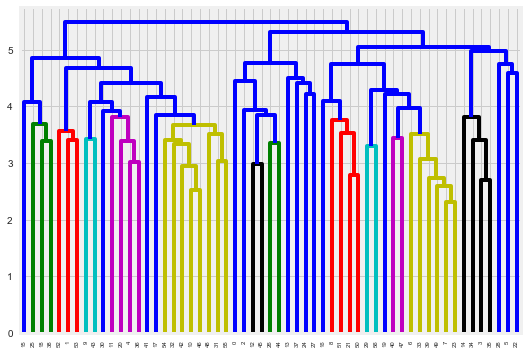

In [85]:
# plot the dendrogram
fig, ax = plt.subplots(figsize=(8,6))
dn = dendrogram(Z)

0.448619972347
0.449864626279
0.427509258472
0.46358121454


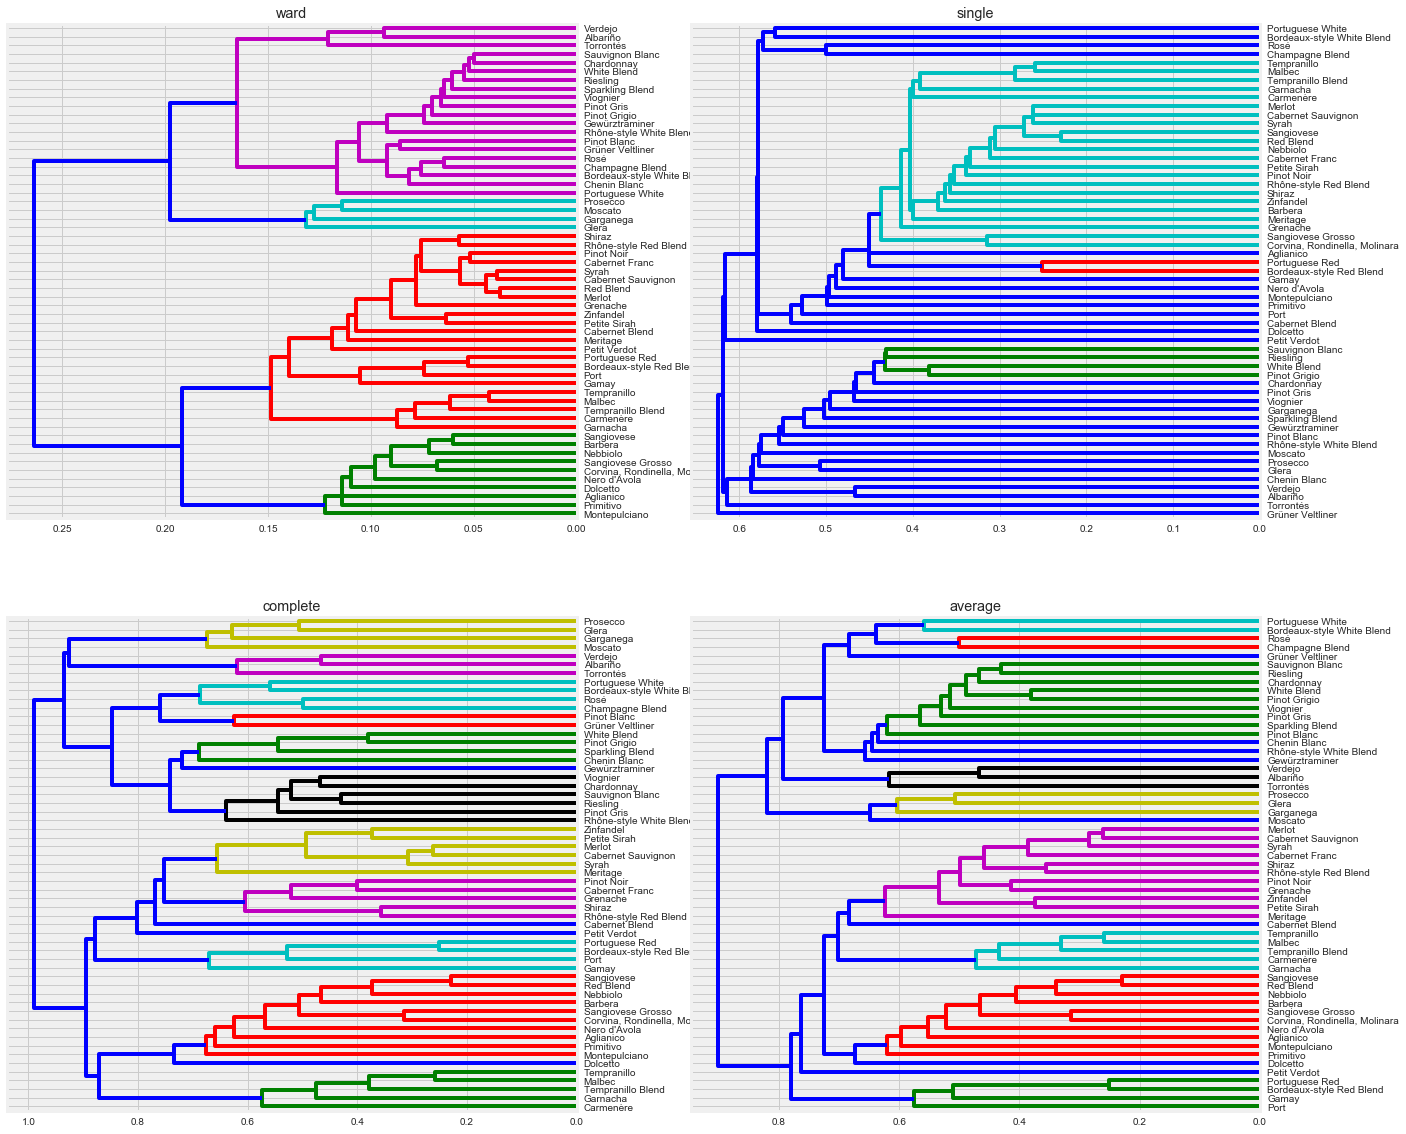

In [79]:
### Here I experiment with different linkages, ward and single never produce as 
### interesting clusters as complete and average
Z_w = linkage(X, 'ward')
Z_s = linkage(X, 'single',metric='cosine')
Z_c = linkage(X, 'complete',metric='cosine')
Z_a = linkage(X, 'average',metric='cosine')

fig, ax = plt.subplots(2,2, figsize=(20,20))

dendrogram(Z_w, orientation='left', labels=test_cluster_df.index, ax=ax[0][0], leaf_font_size=10);
dendrogram(Z_s, orientation='left', labels=test_cluster_df.index, ax=ax[0][1], leaf_font_size=10);
dendrogram(Z_c, orientation='left', labels=test_cluster_df.index, ax=ax[1][0], leaf_font_size=10);
dendrogram(Z_a, orientation='left', labels=test_cluster_df.index, ax=ax[1][1], leaf_font_size=10);

ax[0][0].set_title('ward')
ax[0][1].set_title('single')
ax[1][0].set_title('complete')
ax[1][1].set_title('average')
c_w, coph_dists = cophenet(Z_w, pdist(X))
print c_w
c_s, coph_dists = cophenet(Z_s, pdist(X))
print c_s
c_c, coph_dists = cophenet(Z_c, pdist(X))
print c_c
c_a, coph_dists = cophenet(Z_a, pdist(X))
print c_a

0.475335125697
0.46358121454
0.439784235194
0.427509258472


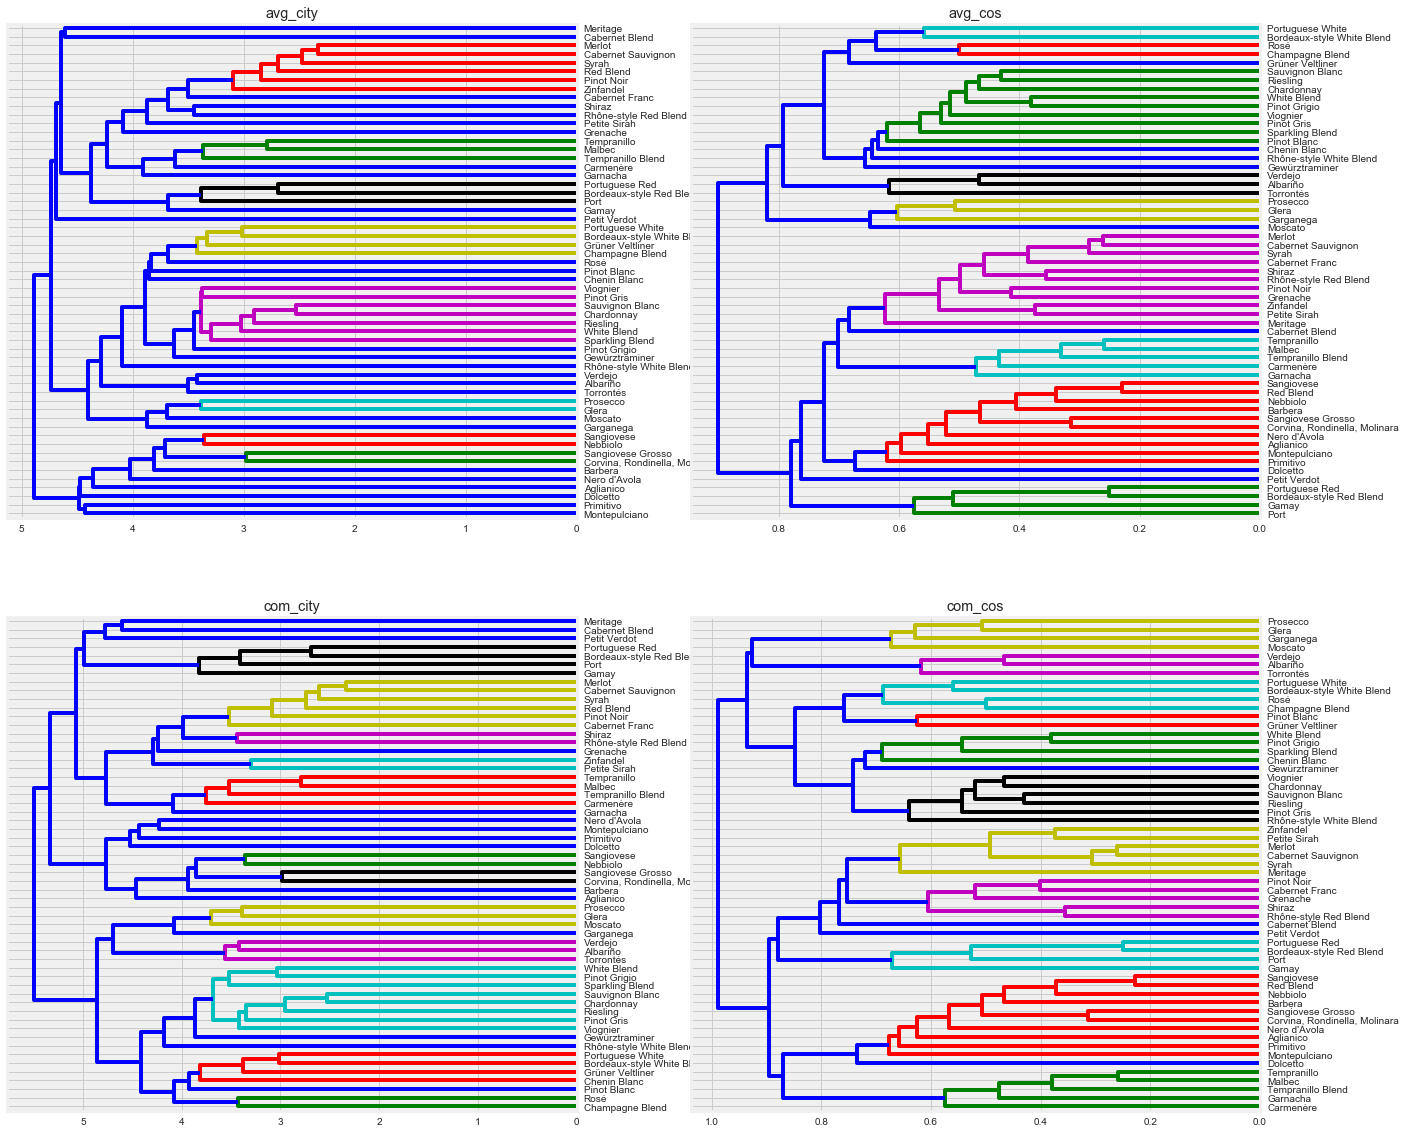

In [80]:
# Here I experiment with average and complete and cityblock and cosine distance metrics as well
Z_w = linkage(X, 'average',metric='cityblock')
Z_s = linkage(X, 'average',metric='cosine')
Z_c = linkage(X, 'complete',metric='cityblock')
Z_a = linkage(X, 'complete',metric='cosine')

fig, ax = plt.subplots(2,2, figsize=(20,20))

dendrogram(Z_w, orientation='left', labels=test_cluster_df.index, ax=ax[0][0], leaf_font_size=10);
dendrogram(Z_s, orientation='left', labels=test_cluster_df.index, ax=ax[0][1], leaf_font_size=10);
dendrogram(Z_c, orientation='left', labels=test_cluster_df.index, ax=ax[1][0], leaf_font_size=10);
dendrogram(Z_a, orientation='left', labels=test_cluster_df.index, ax=ax[1][1], leaf_font_size=10);

ax[0][0].set_title('avg_city')
ax[0][1].set_title('avg_cos')
ax[1][0].set_title('com_city')
ax[1][1].set_title('com_cos')
c_w, coph_dists = cophenet(Z_w, pdist(X))
print c_w
c_s, coph_dists = cophenet(Z_s, pdist(X))
print c_s
c_c, coph_dists = cophenet(Z_c, pdist(X))
print c_c
c_a, coph_dists = cophenet(Z_a, pdist(X))
print c_a

In [86]:
# Now I can pick which one is best to me and print the top words for each group
# even though the index does not change, the columns will change
test_cluster_df.transpose().sort_values('Moscato', ascending=False).head(20).transpose().head()

,white flower,peach honey,based desserts,sweet sparkling,honey peach,peach blossom,flower honey,aromas peach,sweet sparkler,sweet honey,floral aromas,aromas honey,sweet aromas,foamy mousse,apricot honey,crisp acidity,acacia flower,feel mouth,tangerine skin,honey vanilla
variety,,,,,,,,,,,,,,,,,,,,
Aglianico,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.00000,0.001270,0.0,0.001039,0.0,0.000000,0.000822,0.0,0.001078,0.000000,0.000000
Albariño,0.003329,0.0,0.0,0.0,0.000000,0.001266,0.000000,0.006803,0.0,0.00000,0.001957,0.0,0.001084,0.0,0.000000,0.003043,0.0,0.000000,0.001197,0.000000
Barbera,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.00000,0.000000,0.0,0.003308,0.0,0.000000,0.005549,0.0,0.000391,0.000000,0.000000
Bordeaux-style Red Blend,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.00000,0.000050,0.0,0.000157,0.0,0.000000,0.000788,0.0,0.000000,0.000000,0.000000
Bordeaux-style White Blend,0.000290,0.0,0.0,0.0,0.001013,0.000000,0.000427,0.000000,0.0,0.00045,0.000391,0.0,0.000000,0.0,0.001847,0.005292,0.0,0.000000,0.000000,0.000576


### Here I repeate the same process for country, to see if certain countries share similar taste profiles.

In [75]:
test2_cluster_df = newdf.groupby('country').mean()

In [76]:
X_c = test2_cluster_df.iloc[:,0:].as_matrix(columns=None)

In [77]:
Z_c = linkage(X_c, 'complete', metric='cityblock')
c, coph_dists = cophenet(Z_c, pdist(X_c))
print c

0.728150577267


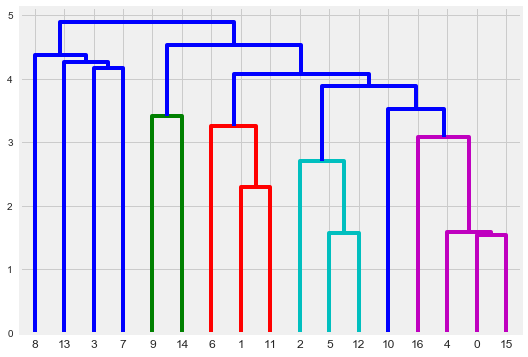

In [78]:
fig, ax = plt.subplots(figsize=(8,6))
dn = dendrogram(Z_c)

0.941138812091
0.695132443513
0.432387516368
0.600736853674


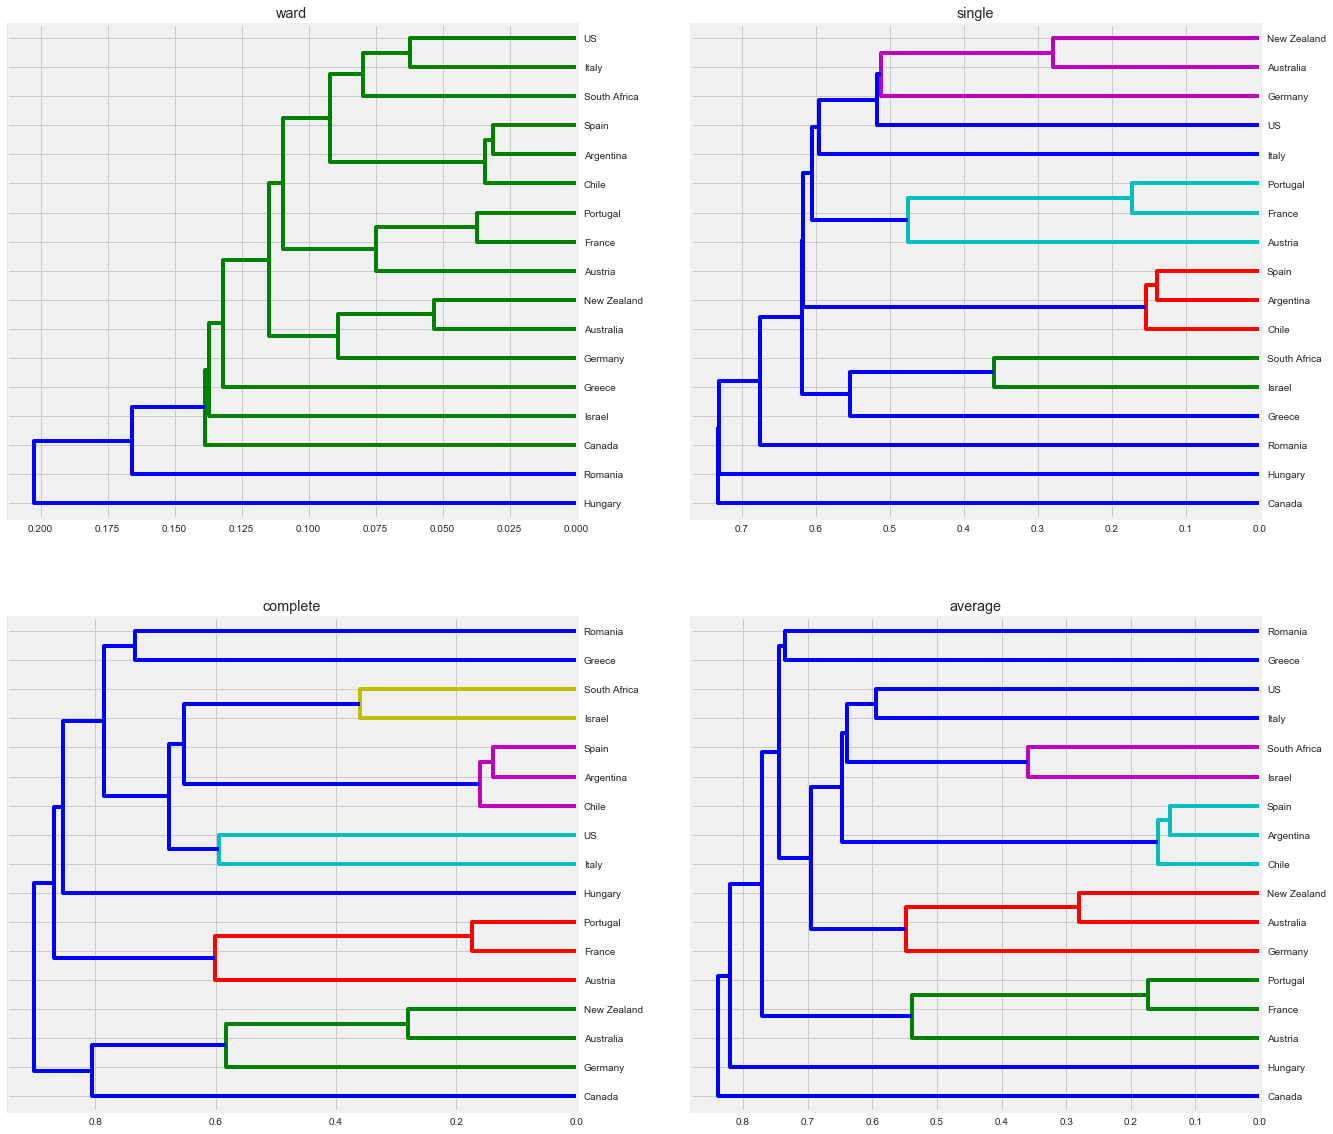

In [80]:
Z_w = linkage(X_c, 'ward')
Z_s = linkage(X_c, 'single',metric='cosine')
Z_c = linkage(X_c, 'complete',metric='cosine')
Z_a = linkage(X_c, 'average',metric='cosine')

fig, ax = plt.subplots(2,2, figsize=(20,20))

dendrogram(Z_w, orientation='left', labels=test2_cluster_df.index, ax=ax[0][0], leaf_font_size=10);
dendrogram(Z_s, orientation='left', labels=test2_cluster_df.index, ax=ax[0][1], leaf_font_size=10);
dendrogram(Z_c, orientation='left', labels=test2_cluster_df.index, ax=ax[1][0], leaf_font_size=10);
dendrogram(Z_a, orientation='left', labels=test2_cluster_df.index, ax=ax[1][1], leaf_font_size=10);

ax[0][0].set_title('ward')
ax[0][1].set_title('single')
ax[1][0].set_title('complete')
ax[1][1].set_title('average')
c_w, coph_dists = cophenet(Z_w, pdist(X_c))
print c_w
c_s, coph_dists = cophenet(Z_s, pdist(X_c))
print c_s
c_c, coph_dists = cophenet(Z_c, pdist(X_c))
print c_c
c_a, coph_dists = cophenet(Z_a, pdist(X_c))
print c_a

0.838939020032
0.600736853674
0.728150577267
0.432387516368


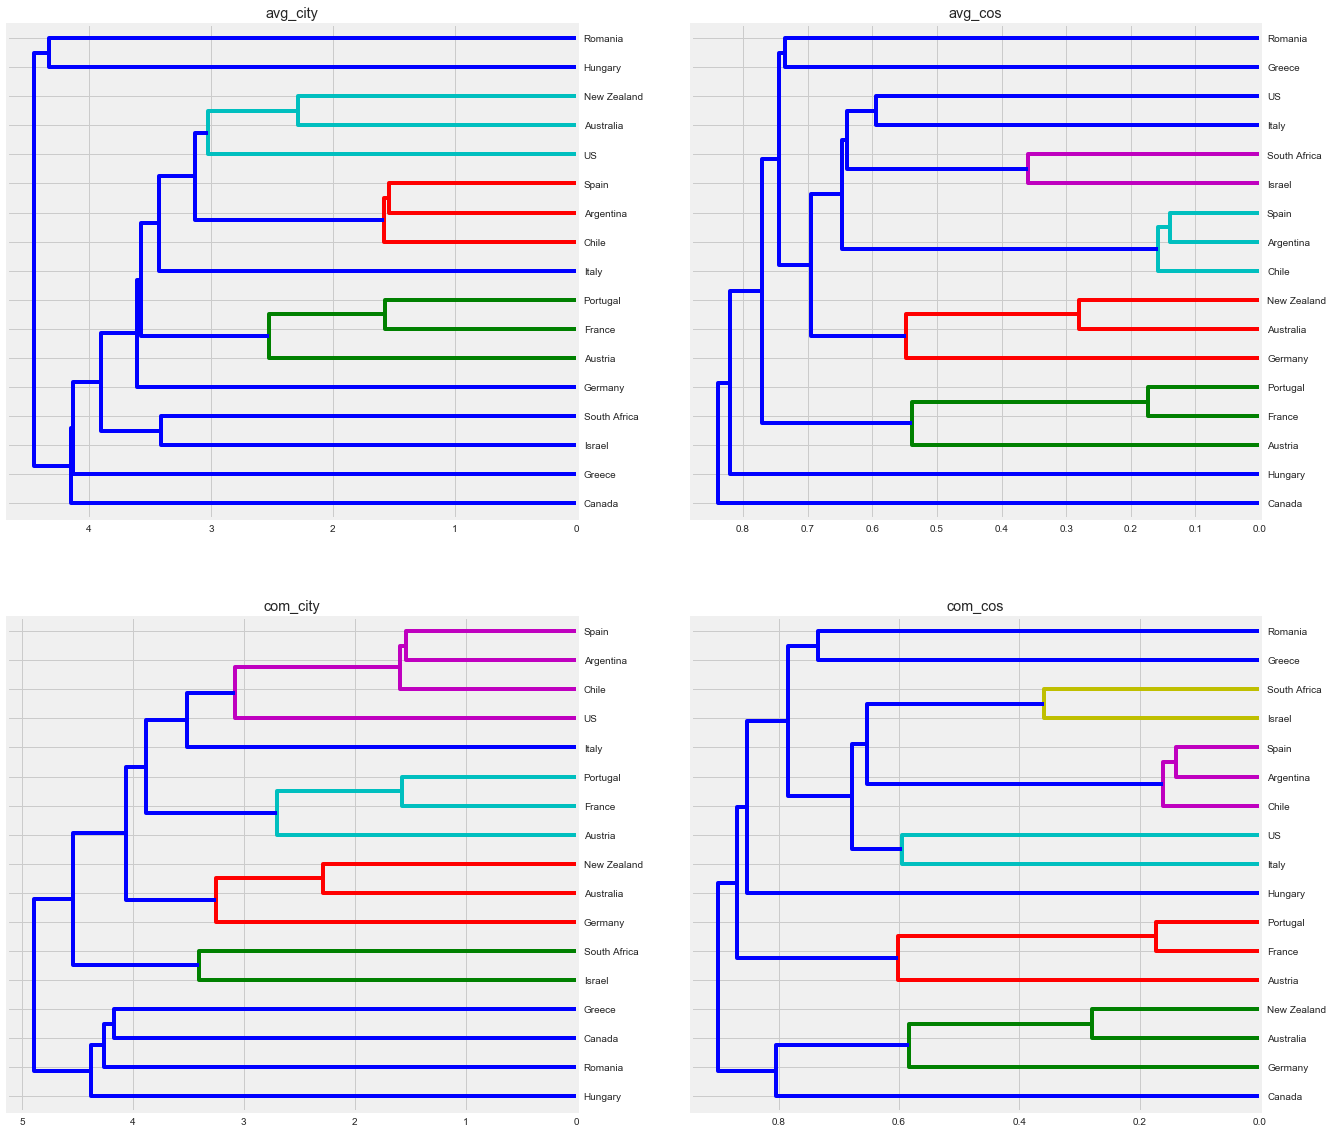

In [81]:
Z_w = linkage(X_c, 'average',metric='cityblock')
Z_s = linkage(X_c, 'average',metric='cosine')
Z_c = linkage(X_c, 'complete',metric='cityblock')
Z_a = linkage(X_c, 'complete',metric='cosine')

fig, ax = plt.subplots(2,2, figsize=(20,20))

dendrogram(Z_w, orientation='left', labels=test2_cluster_df.index, ax=ax[0][0], leaf_font_size=10);
dendrogram(Z_s, orientation='left', labels=test2_cluster_df.index, ax=ax[0][1], leaf_font_size=10);
dendrogram(Z_c, orientation='left', labels=test2_cluster_df.index, ax=ax[1][0], leaf_font_size=10);
dendrogram(Z_a, orientation='left', labels=test2_cluster_df.index, ax=ax[1][1], leaf_font_size=10);

ax[0][0].set_title('avg_city')
ax[0][1].set_title('avg_cos')
ax[1][0].set_title('com_city')
ax[1][1].set_title('com_cos')
c_w, coph_dists = cophenet(Z_w, pdist(X_c))
print c_w
c_s, coph_dists = cophenet(Z_s, pdist(X_c))
print c_s
c_c, coph_dists = cophenet(Z_c, pdist(X_c))
print c_c
c_a, coph_dists = cophenet(Z_a, pdist(X_c))
print c_a

In [82]:
test2_cluster_df.transpose().sort_values('Canada', ascending=False).head(10).transpose().head()

,orange peel,aromatic notes,wet stone,french oak,fresh apple,drinks dry,five grape,alcohol seems,citrus apple,aromas fresh
country,,,,,,,,,,
Argentina,0.001812,0.000277,0.000000,0.000986,0.000247,0.000000,0.000458,0.000000,0.001002,0.001993
Australia,0.000505,0.000000,0.001576,0.002902,0.000452,0.000188,0.000000,0.000203,0.000147,0.001375
Austria,0.001435,0.000529,0.000000,0.000200,0.002216,0.000000,0.000000,0.000000,0.000754,0.000491
Canada,0.016003,0.015211,0.014636,0.013937,0.013204,0.013014,0.011907,0.011254,0.010985,0.010432
Chile,0.000980,0.000113,0.000280,0.000297,0.000637,0.000000,0.000642,0.000196,0.001557,0.001565


### Here I do the process again for province, to get even more precise geographically. I only look at provinces that have atleast 500 descriptions

In [83]:
pro_filt_df = newdf[newdf.groupby('province')['province'].transform('size') > 500]

In [84]:
test3_cluster_df = pro_filt_df.groupby('province').mean()

In [85]:
test3_cluster_df.head()

,abound nose,absolutely delicious,absolutely dry,acacia flower,accents black,accents bright,accents chocolate,accents cinnamon,accents core,accents dark,...,zesty crisp,zesty finish,zesty fresh,zesty freshness,zesty grapefruit,zesty green,zesty lemon,zesty lime,zesty texture,zingy acidity
province,,,,,,,,,,,,,,,,,,,,,
Alentejano,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.001590,0.000000,0.000000,0.000000,0.000000,0.001085,0.000958,0.000000
Alsace,0.0,0.00000,0.000323,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000373,0.000341,0.000719,0.001923,0.000451,0.000000,0.002407,0.000461,0.000592,0.000000
Bordeaux,0.0,0.00000,0.000000,0.000000,0.000086,0.000088,0.000000,0.000000,0.0,0.000000,...,0.000089,0.000000,0.000000,0.000000,0.000113,0.000000,0.000091,0.000095,0.000100,0.000000
Burgundy,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000416,0.000000,0.000000,0.000650,0.000138,0.000308,0.000000,0.001327,0.000000
California,0.0,0.00061,0.000733,0.000034,0.000152,0.000077,0.000015,0.000178,0.0,0.000079,...,0.000028,0.000060,0.000028,0.000000,0.000070,0.000053,0.000142,0.000077,0.000000,0.000464


In [86]:
X_c = test3_cluster_df.iloc[:,0:].as_matrix(columns=None)

In [87]:
Z_c = linkage(X_c, 'complete', metric='cityblock')
c, coph_dists = cophenet(Z_c, pdist(X_c))
print c

0.737736384755


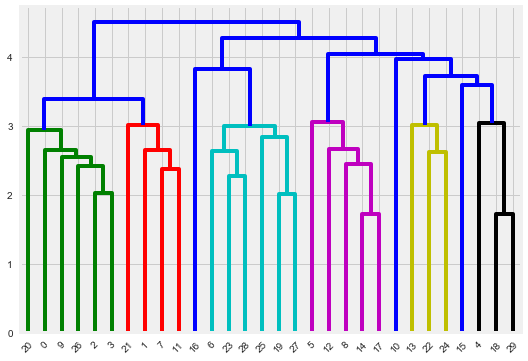

In [88]:
fig, ax = plt.subplots(figsize=(8,6))
dn = dendrogram(Z_c)

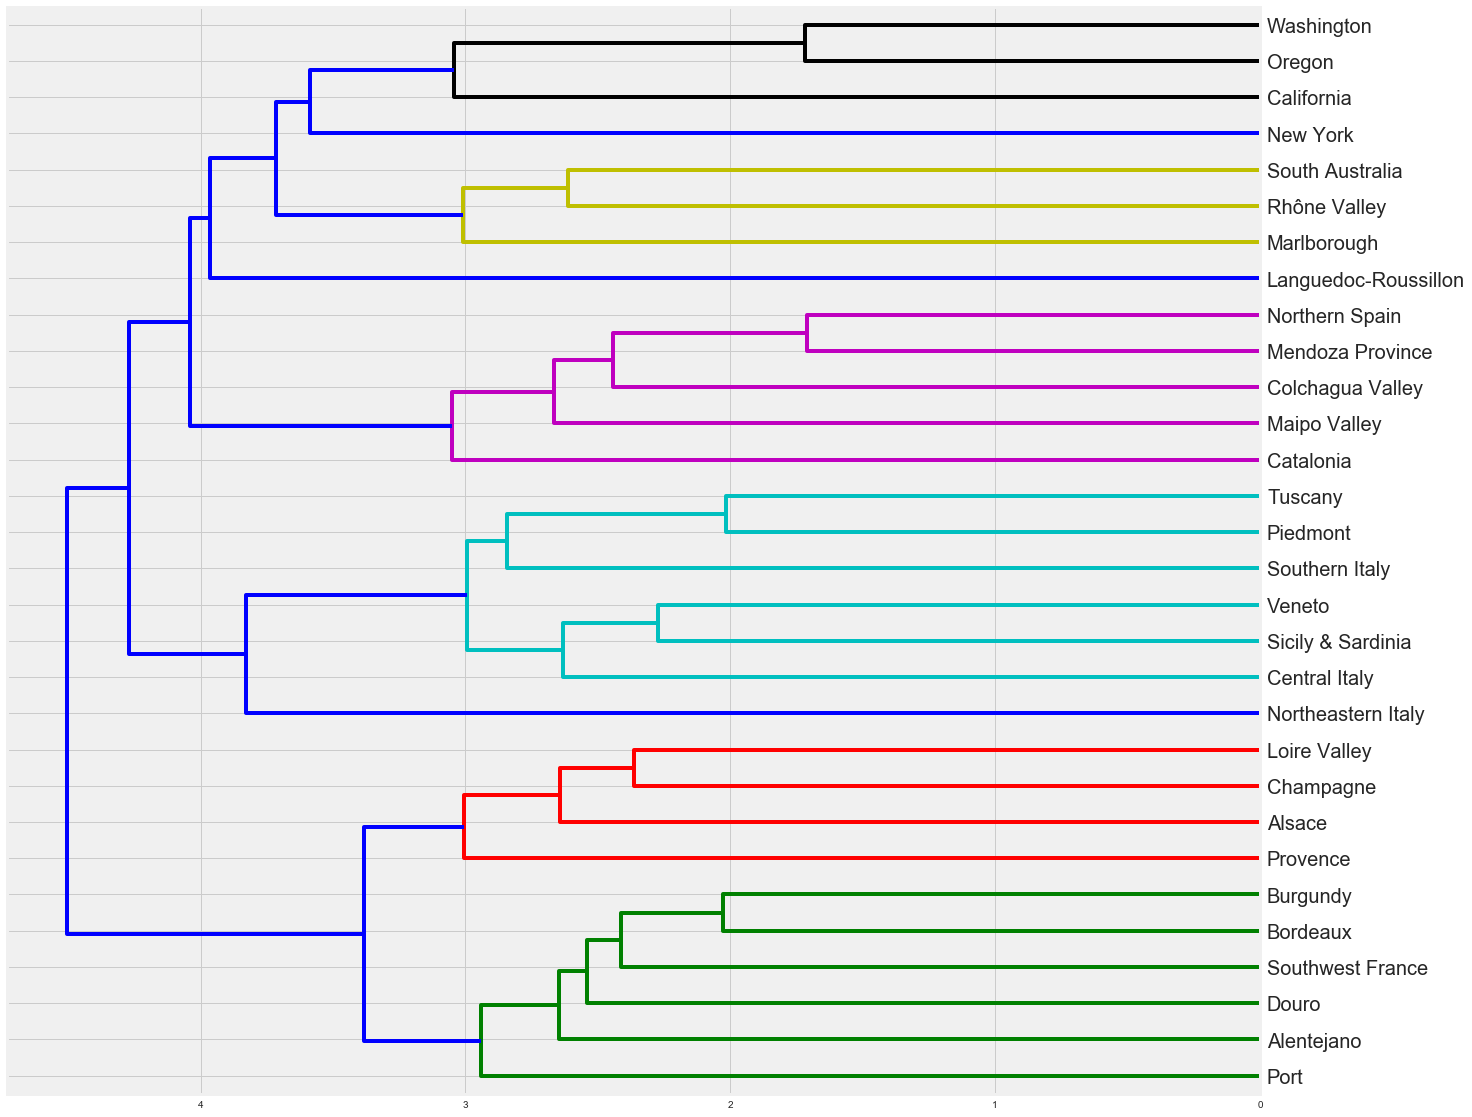

In [89]:
fig, ax = plt.subplots(figsize=(20,20))
dn = dendrogram(Z_c, orientation='left', labels=test3_cluster_df.index, ax=ax, leaf_font_size=20)

0.696856879286
0.745158185736
0.746781867137
0.826776567681


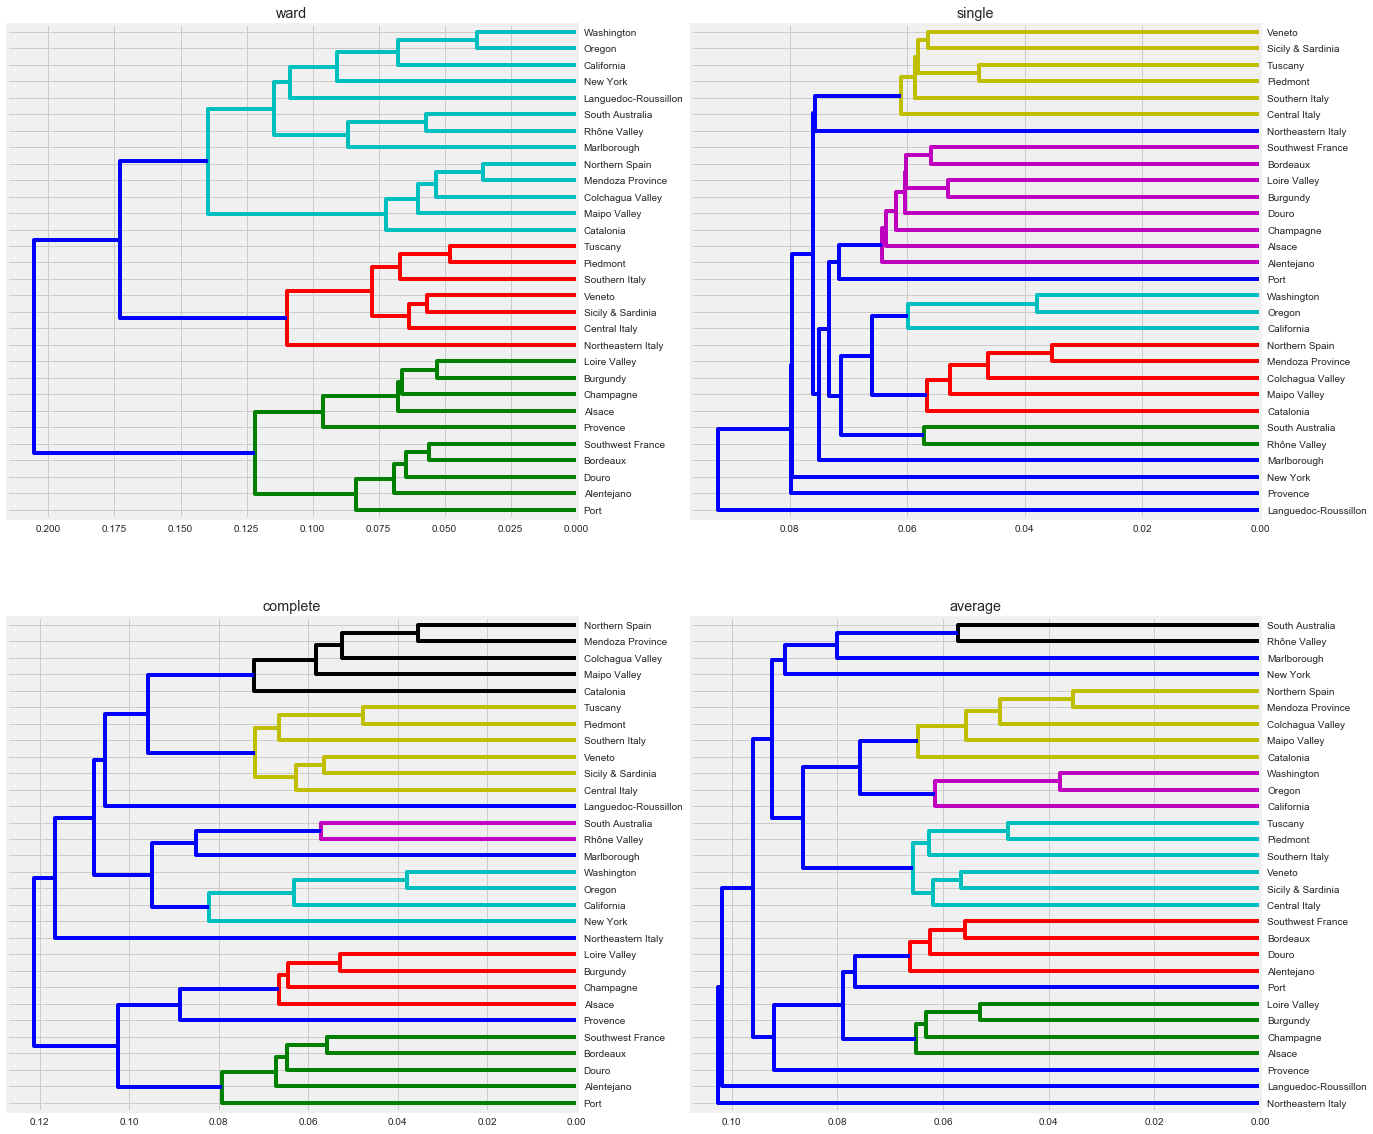

In [90]:
Z_w = linkage(X_c, 'ward')
Z_s = linkage(X_c, 'single')
Z_c = linkage(X_c, 'complete')
Z_a = linkage(X_c, 'average')

fig, ax = plt.subplots(2,2, figsize=(20,20))

dendrogram(Z_w, orientation='left', labels=test3_cluster_df.index, ax=ax[0][0], leaf_font_size=10);
dendrogram(Z_s, orientation='left', labels=test3_cluster_df.index, ax=ax[0][1], leaf_font_size=10);
dendrogram(Z_c, orientation='left', labels=test3_cluster_df.index, ax=ax[1][0], leaf_font_size=10);
dendrogram(Z_a, orientation='left', labels=test3_cluster_df.index, ax=ax[1][1], leaf_font_size=10);

ax[0][0].set_title('ward')
ax[0][1].set_title('single')
ax[1][0].set_title('complete')
ax[1][1].set_title('average')
c_w, coph_dists = cophenet(Z_w, pdist(X_c))
print c_w
c_s, coph_dists = cophenet(Z_s, pdist(X_c))
print c_s
c_c, coph_dists = cophenet(Z_c, pdist(X_c))
print c_c
c_a, coph_dists = cophenet(Z_a, pdist(X_c))
print c_a

0.742282151955
0.826776567681
0.737736384755
0.746781867137


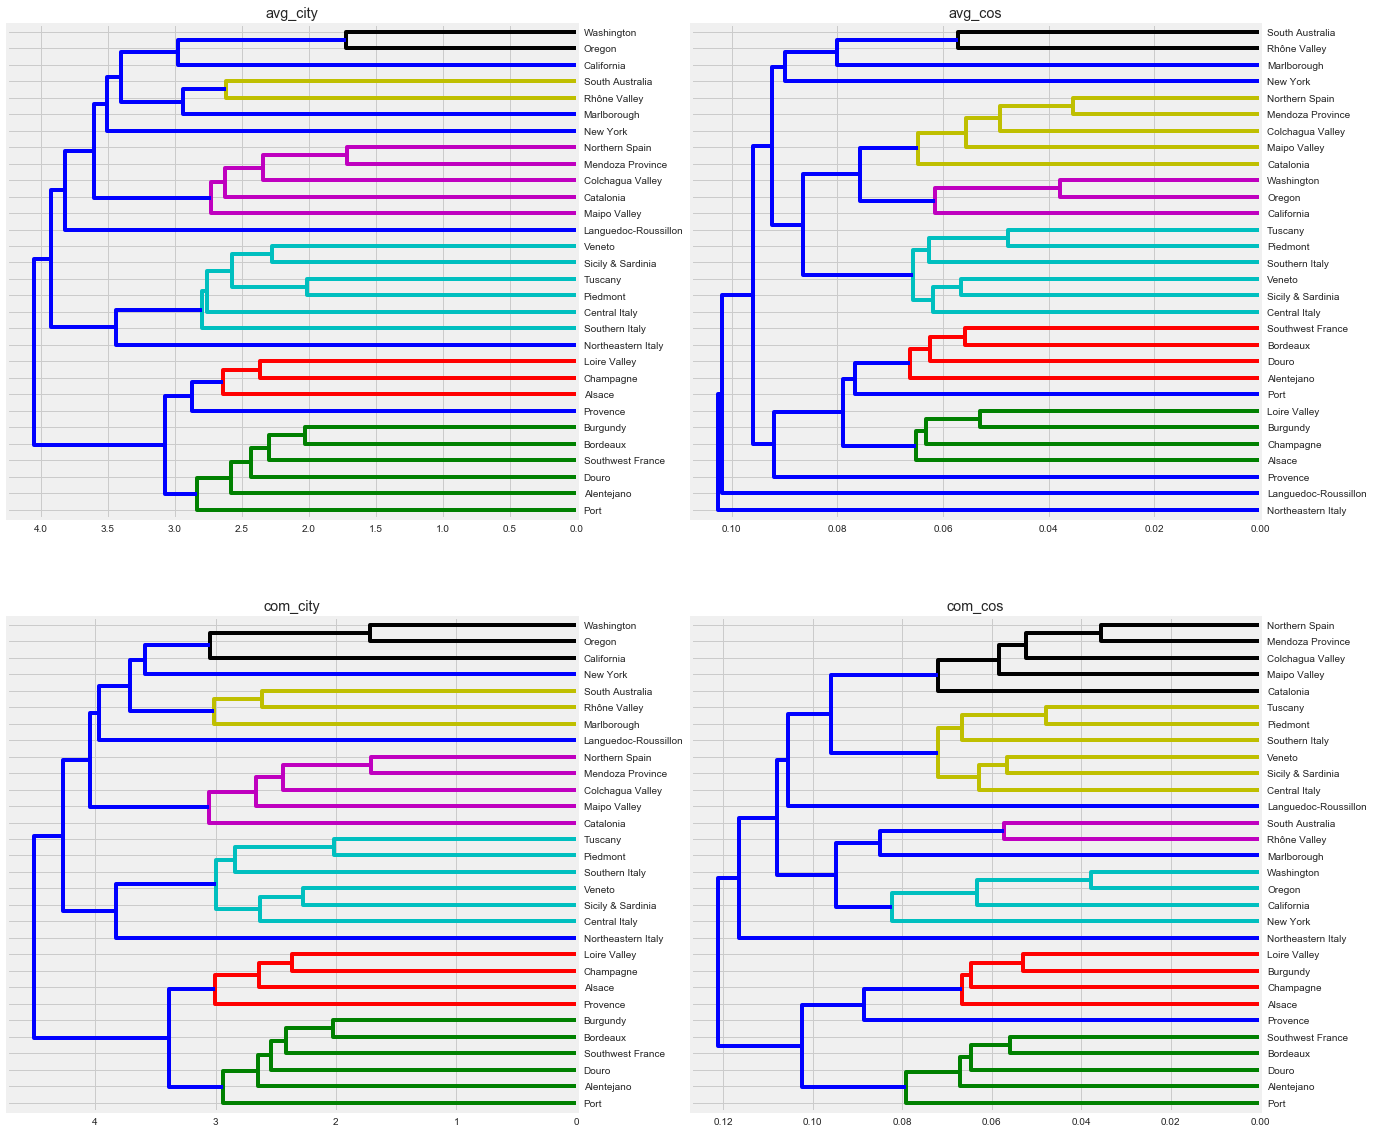

In [91]:
Z_w = linkage(X_c, 'average',metric='cityblock')
Z_s = linkage(X_c, 'average')
Z_c = linkage(X_c, 'complete',metric='cityblock')
Z_a = linkage(X_c, 'complete')

fig, ax = plt.subplots(2,2, figsize=(20,20))

dendrogram(Z_w, orientation='left', labels=test3_cluster_df.index, ax=ax[0][0], leaf_font_size=10);
dendrogram(Z_s, orientation='left', labels=test3_cluster_df.index, ax=ax[0][1], leaf_font_size=10);
dendrogram(Z_c, orientation='left', labels=test3_cluster_df.index, ax=ax[1][0], leaf_font_size=10);
dendrogram(Z_a, orientation='left', labels=test3_cluster_df.index, ax=ax[1][1], leaf_font_size=10);

ax[0][0].set_title('avg_city')
ax[0][1].set_title('avg_cos')
ax[1][0].set_title('com_city')
ax[1][1].set_title('com_cos')
c_w, coph_dists = cophenet(Z_w, pdist(X_c))
print c_w
c_s, coph_dists = cophenet(Z_s, pdist(X_c))
print c_s
c_c, coph_dists = cophenet(Z_c, pdist(X_c))
print c_c
c_a, coph_dists = cophenet(Z_a, pdist(X_c))
print c_a

In [96]:
test3_cluster_df.transpose().sort_values('Northeastern Italy', ascending=False).head(10).transpose().head()

,white peach,fresh acidity,crisp acidity,green apple,aromas citrus,tomato leaf,honeydew melon,aromas peach,aromas stone,ribolla gialla
province,,,,,,,,,,
Alentejano,0.001498,0.008610,0.001141,0.001628,0.000000,0.000000,0.000000,0.000000,0.0,0.00000
Alsace,0.001479,0.004909,0.003851,0.007136,0.000000,0.000000,0.000644,0.000308,0.0,0.00000
Bordeaux,0.000363,0.007387,0.001911,0.001372,0.000000,0.000000,0.000000,0.000000,0.0,0.00000
Burgundy,0.001869,0.009255,0.004516,0.003924,0.000104,0.000000,0.000000,0.000000,0.0,0.00000
California,0.001729,0.000461,0.008797,0.004012,0.000033,0.000166,0.000398,0.000032,0.0,0.00002


## Deep Learning 
### Here I can scan my descriptions into one large corpus that a model can learn on. I can then provide a word in the vocublary and it will return words it has deemed most similar. This could be handy for getting fresh descriptions by changing up word choice. You could get a sense of what sommeliers mean by there use of certain words.

In [73]:
import gensim.models.word2vec as w2v

Using Theano backend.


In [74]:
newer.shape

(88809, 10)

## I process my descriptions in chunks for speed.

In [75]:
labels = newer['variety']
descriptions = newer2['description'][0:10000]
descriptions2 = newer2['description'][10000:20000]
descriptions3 = newer2['description'][30000:40000]
descriptions4 = newer2['description'][50000:60000]
descriptions5 = newer2['description'][70000:80000]
descriptions6 = newer2['description'][80000:88809]


In [76]:
corpus_raw = ""
for i in descriptions:
    corpus_raw += i
print(len(corpus_raw))

2450647


In [77]:
for i in descriptions2:
    corpus_raw += i
print(len(corpus_raw))

4822115


In [78]:
for i in descriptions3:
    corpus_raw += i
print(len(corpus_raw))

7157375


In [79]:
for i in descriptions4:
    corpus_raw += i
print(len(corpus_raw))

9591024


In [80]:
for i in descriptions5:
    corpus_raw += i
print(len(corpus_raw))

12055100


In [81]:
for i in descriptions6:
    corpus_raw += i
print(len(corpus_raw))

14206744


## Here I break my descriptions and clean them and reassemble them into sentences that I pass to the deep learning module.

In [ ]:
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle',encoding='utf8')

In [83]:
raw_sentences = tokenizer.tokenize(corpus_raw.decode('utf8'))

In [84]:
def sentence_to_wordlist(raw):
    clean = re.sub("[^a-zA-Z]"," ", raw)
    words = clean.split()
    return words

In [85]:
sentences = []
for raw_sentence in raw_sentences:
    if len(raw_sentence) > 0:
        sentences.append(sentence_to_wordlist(raw_sentence))

In [86]:
token_count = sum([len(sentence) for sentence in sentences])
print('The wine corpus contains {0:,} tokens'.format(token_count))

The wine corpus contains 2,422,229 tokens


In [87]:
num_features = 1000
min_word_count = 15
num_workers = multiprocessing.cpu_count()
context_size = 10
downsampling = 1e-3
seed=1992

In [88]:
wine2vec = w2v.Word2Vec(
    sg=1,
    seed=seed,
    workers=num_workers,
    size=num_features,
    min_count=min_word_count,
    window=context_size,
    sample=downsampling,
)

In [89]:
wine2vec.build_vocab(sentences)

In [90]:
print('Word2Vec vocabulary length:', len(wine2vec.wv.vocab))

('Word2Vec vocabulary length:', 5869)


In [91]:
print(wine2vec.corpus_count)

105875


In [92]:
wine2vec.train(sentences, total_examples=wine2vec.corpus_count, epochs=wine2vec.iter)

8504105

## I can put in key words and find what words are most similar

In [93]:
wine2vec.most_similar('acidity')

[(u'acids', 0.6581054925918579),
 (u'Acidity', 0.6076356768608093),
 (u'crispness', 0.5378366708755493),
 (u'brightening', 0.5215674042701721),
 (u'Fortunately', 0.5208887457847595),
 (u'acid', 0.5106472969055176),
 (u'Freshness', 0.5097158551216125),
 (u'boosts', 0.5065231919288635),
 (u'Acids', 0.5046905875205994),
 (u'pierced', 0.5042442083358765)]

In [94]:
wine2vec.most_similar('dry')

[(u'dryish', 0.577743649482727),
 (u'drily', 0.5656476616859436),
 (u'mouthwateringly', 0.5351825952529907),
 (u'astringently', 0.5217846632003784),
 (u'dryness', 0.5030202269554138),
 (u'Dry', 0.5001981258392334),
 (u'briskly', 0.4978885054588318),
 (u'rasping', 0.49723413586616516),
 (u'scour', 0.49435171484947205),
 (u'cherryskin', 0.49217551946640015)]

In [ ]:
wine2vec.most_similar('oak')